<a href="https://colab.research.google.com/github/martinolin/Martin/blob/master/miniproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Miniproject D7041E

This miniproject aims for grade 4


*   Run and understand a publicly available model on a one selected data set -https://www.kaggle.com/code/rakaputrawidyasf/fashion-mnist-with-k-fold-cross-validation
*   Choose a dataset - Fashion-mnist, downloaded from https://github.com/fpleoni/fashion_mnist/tree/master
* Test performance for different configurations of the perceptron (test several numbers of hidden layers, sizes of hidden layers, different cost functions) - tries different numbers of conv and dense layers, tries two cost functions: categorical_crossentropy and KLDivergence
* Document the performance - the results is documented
* Perform an extensive set of experiments and valuate the performance of ONE existing model on the chosen use-case. -crossvalidation gives lots of tests, different variations of the models are tested.


* you should use data pre-processing,  -performs whitening of the images
* systematically choose the hyper-parameters of the model - test different kernelsize of the Conv2D layers
* Use cross-validation for training - yes
* Use different seeds and  recorded performance statistics with various performance metrics (Accuracy, recall, f-score etc.) -yes


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import seaborn as sn

import tensorflow as tf
import keras

In [ ]:
#Load
#downloaded from https://github.com/fpleoni/fashion_mnist/tree/master
train_set = pd.read_csv("fashion-mnist_train.csv")
testing_set = pd.read_csv("fashion-mnist_test.csv")
train_set = np.array(train_set, dtype="float32")
testing_set = np.array(testing_set, dtype="float32")

# PreProcessing

In [ ]:
def PreProccesingWhitenNormalizeAndReshape(X):
    #one image per row: #data was loaded in this shape...
    #X=nparrayOfImages.reshape(nparrayOfImages.shape[0],nparrayOfImages.shape[1]*nparrayOfImages.shape[2]).astype(np.float32)
    #normalize all images:
    for x in range(X.shape[0]):
        X[x-1,:]=(X[x-1,:] - X[x-1,:].min()) / (X[x-1,:].max() - X[x-1,:].min())
    #subtract mean Values Per Pixel Over All Images
    X_norm=X-X.mean(axis=0)
    #get covariance over all pixels using column as variables and rows as obersvations
    cov=np.cov(X_norm, rowvar=False)
    #svd and
    U,S,V=np.linalg.svd(cov)
    epsilon=0.1
    X_ZCA=U.dot(np.diag(1.0/np.sqrt(S+epsilon))).dot(U.T).dot(X_norm.T).T
    #resclae
    X_ZCA=(X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())

    return X_ZCA.reshape(X.shape[0],28,28,1)

In [ ]:
X = (train_set[:, 1:])
X_test = (testing_set[:, 1:])


# For labels
y = train_set[:, 0]
y_test = testing_set[:, 0]


In [ ]:
#due to memory constraint on this computer i will only use half of the data for training, we will use 3-fold cross validation



#X_test=X_test[1:500,:]
X=X[1:30000,:]
#y_test=y_test[1:500]
y=y[1:30000]

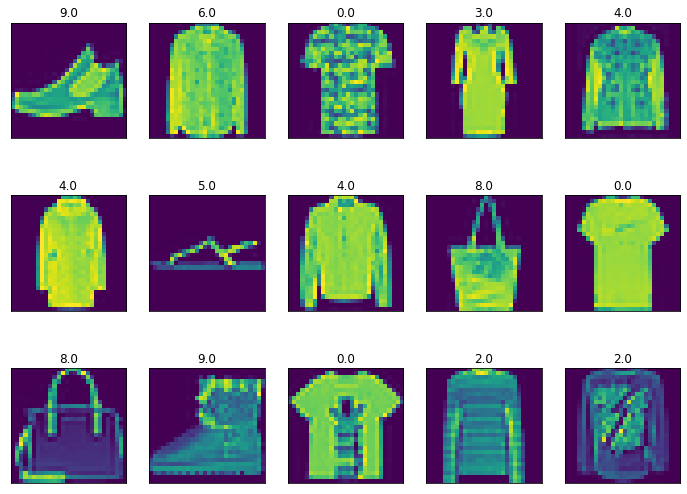

In [ ]:
#display some images before processsing
plt.figure(figsize=(12, 9))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i].reshape((28, 28, 1)))
    plt.title(y[i])
plt.show()

In [ ]:
X=PreProccesingWhitenNormalizeAndReshape(X)
X_test=PreProccesingWhitenNormalizeAndReshape(X_test)

In [ ]:
X.shape

(29999, 28, 28, 1)

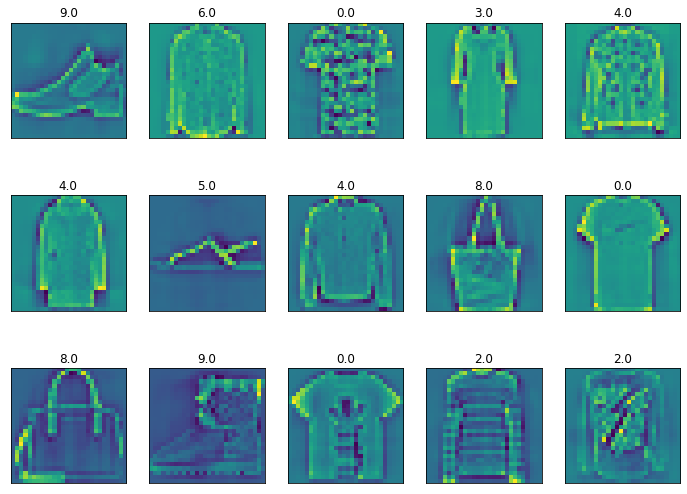

In [ ]:
#display some images after processsing
plt.figure(figsize=(12, 9))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i])
    plt.title(y[i])
plt.show()

In [ ]:
# Transform labels to categorical
y = keras.utils.to_categorical(y)
y_test = keras.utils.to_categorical(y_test)

In [ ]:
# prepare some performance statistics
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
#Define the CNN Model
def pickCostFunctionAndMakeModel(model,costfunction):
    model.compile(optimizer="adam",
                  loss=costfunction,
                  metrics=["accuracy", f1_m,precision_m, recall_m])
    return model


input_shape = (28, 28, 1)
def sequential_model(input_shape, numberOfHiddenConv2dPoolingLayers=0, numberOfDenseHiddenLayers=0, kernelsize=3,costFunction='categorical_crossentropy'):
    model = keras.Sequential()
    nextLayerSize=32
    for i in range(0,numberOfHiddenConv2dPoolingLayers+2):
        model.add(keras.layers.Conv2D(nextLayerSize, (kernelsize, kernelsize), activation="relu",input_shape=input_shape))
        model.add(keras.layers.MaxPooling2D(2, 2))
        nextLayerSize=nextLayerSize*2
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(nextLayerSize, activation="relu"))
    for i in range(0,numberOfDenseHiddenLayers):
        model.add(keras.layers.Dense(nextLayerSize, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))
    model=pickCostFunctionAndMakeModel(model,costFunction)

    return model





In [ ]:
input_shape = (28, 28, 1)
#the cost function categorical_crossentropy is meant for multiclassification problems, but we can also test with another costfunction like mean square error:
#model_MSE=sequential_model(input_shape, 0, costFunction='mse')


#but lets also use categorical_croosentropy:
#model_MSE=sequential_model(input_shape, 0, 3,costFunction='categorical_crossentropy')


In [ ]:
def Average(input):
    return sum(input)/len(input)

def EvaluateModel(model):
    #Configure Training & Validation (K-Fold) Properties

    k = 3
    cross_val = KFold(k, shuffle=True, random_state=1)
    fold_count = 1

    # For training epochs
    epochs = 32

    # For evaluations per epoch
    histories = []

    # For testing/evaluation acc scores
    accuracy_scores = []
    #losses_scores=[]
    f1_scores=[]
    precision_scores=[]
    recall_scores=[]
    # For callbacks
    es_callbacks = keras.callbacks.EarlyStopping(monitor="val_loss",
                                          mode="min",
                                          verbose=1,
                                          patience=4)
    for train, validation in cross_val.split(X):
        print("="*80)
        print("Fold-{}".format(fold_count))
        print("-"*80)
        print("Training & Validation")
        fold_count = fold_count + 1

        #model = sequential_model((28,28,1), numberOfHiddenConv2dPoolingLayers=1,kernelsize=3,costFunction='categorical_crossentropy')#only 1 or 0 extra hidden conv2d+pooling layers can be added
        #model = sequential_model((28,28,1))
        X_train, y_train = X[train], y[train]
        X_val, y_val = X[validation], y[validation]

        history = model.fit(X_train, y_train,epochs=epochs,validation_data=(X_val, y_val),callbacks=[es_callbacks])

        print("-"*80)
        print("Testing/evaluation")
        eval_loss, eval_accuracy, eval_f1,eval_precision, eval_recall = model.evaluate(X_test, y_test)

        histories.append(history)
        #losses_scores.appened(eval_loss)
        accuracy_scores.append(eval_accuracy)
        f1_scores.append(eval_f1)
        precision_scores.append(eval_precision)
        recall_scores.append(eval_recall)
        print("_"*80)
    return Average(accuracy_scores), Average(f1_scores),Average(precision_scores), Average(recall_scores)

In [ ]:
models=[]

kernelsize_alt=[5,3,3,3,3,3]
numberOfHiddenConv2dPoolingLayers_alt=[0,0,1,0,0,0]
numberOfDenseHiddenLayers_alt=[0,0,0,1,2,0]
costFunction_alt=["categorical_crossentropy","categorical_crossentropy","categorical_crossentropy","categorical_crossentropy","categorical_crossentropy","mse"]
for i in range(0,len(costFunction_alt)):
    models.append(sequential_model(input_shape, numberOfHiddenConv2dPoolingLayers=numberOfHiddenConv2dPoolingLayers_alt[i],numberOfDenseHiddenLayers=numberOfDenseHiddenLayers_alt[i],kernelsize=kernelsize_alt[i],costFunction=costFunction_alt[i]))


In [ ]:
results=[]
for model in models:
    print(model.summary())
    print("lossfunction: "+ str(model.compiled_loss.get_config()["losses"]))
    results.append(EvaluateModel(model))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 4, 4, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 128)              

In [ ]:
print(results)

[(0.8784666657447815, 0.8794575929641724, 0.8906316757202148, 0.86890975634257), (0.8915666739145914, 0.892405092716217, 0.8999195496241251, 0.8852502703666687), (0.8589333295822144, 0.8601500590642294, 0.8717198173205057, 0.8492411971092224), (0.8873999913533529, 0.8884267012278239, 0.8937576413154602, 0.8833200136820475), (0.8852666616439819, 0.8863863746325175, 0.8917502562204996, 0.8812566598256429), (0.8868333299954733, 0.8877023259798685, 0.8965005874633789, 0.8793264230092367)]


In [ ]:
print("accuracy_scores: (TN+TP)/(TN+FP+FN+TP)")
for i in range(0,len(models)):
    print(results[i][0])
print("f1_scores: 2 * (precision * recall)/(precision + recall)")
for i in range(0,len(models)):
    print(results[i][1])
print("precision_scores: TP/(TP+FP)")
for i in range(0,len(models)):
    print(results[i][2])
print("recall_scores (Sensitivity): TP/(TP+FN)")
for i in range(0,len(models)):
    print(results[i][3])



accuracy_scores: (TN+TP)/(TN+FP+FN+TP)
0.8784666657447815
0.8915666739145914
0.8589333295822144
0.8873999913533529
0.8852666616439819
0.8868333299954733
f1_scores: 2 * (precision * recall)/(precision + recall)
0.8794575929641724
0.892405092716217
0.8601500590642294
0.8884267012278239
0.8863863746325175
0.8877023259798685
precision_scores: TP/(TP+FP)
0.8906316757202148
0.8999195496241251
0.8717198173205057
0.8937576413154602
0.8917502562204996
0.8965005874633789
recall_scores (Sensitivity): TP/(TP+FN)
0.86890975634257
0.8852502703666687
0.8492411971092224
0.8833200136820475
0.8812566598256429
0.8793264230092367


In [ ]:
print("for table")
for i in range(0,len(models)):
    print( "| " + str(numberOfHiddenConv2dPoolingLayers_alt[i]) + " | " + str(numberOfDenseHiddenLayers_alt[i]) + " | " + str(kernelsize_alt[i]) + " | " + str(costFunction_alt[i]) +str(results[i][0]) +" | " +str(results[i][1]) +" | " +str(results[i][2]) +" | " +str(results[i][3]) +" | ")

for table
| 0 | 0 | 5 | categorical_crossentropy0.8784666657447815 | 0.8794575929641724 | 0.8906316757202148 | 0.86890975634257 | 
| 0 | 0 | 3 | categorical_crossentropy0.8915666739145914 | 0.892405092716217 | 0.8999195496241251 | 0.8852502703666687 | 
| 1 | 0 | 3 | categorical_crossentropy0.8589333295822144 | 0.8601500590642294 | 0.8717198173205057 | 0.8492411971092224 | 
| 0 | 1 | 3 | categorical_crossentropy0.8873999913533529 | 0.8884267012278239 | 0.8937576413154602 | 0.8833200136820475 | 
| 0 | 2 | 3 | categorical_crossentropy0.8852666616439819 | 0.8863863746325175 | 0.8917502562204996 | 0.8812566598256429 | 
| 0 | 0 | 3 | mse0.8868333299954733 | 0.8877023259798685 | 0.8965005874633789 | 0.8793264230092367 | 



| extra conv2d | extra dense layers | kernelsize | costfunction | Accuracy | F1_scores | Precision | Recall |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 0 | 0 | 5 | categorical_crossentropy0.8784666657447815 | 0.8794575929641724 | 0.8906316757202148 | 0.86890975634257 |
| 0 | 0 | 3 | categorical_crossentropy0.8915666739145914 | 0.892405092716217 | 0.8999195496241251 | 0.8852502703666687 |
| 1 | 0 | 3 | categorical_crossentropy0.8589333295822144 | 0.8601500590642294 | 0.8717198173205057 | 0.8492411971092224 |
| 0 | 1 | 3 | categorical_crossentropy0.8873999913533529 | 0.8884267012278239 | 0.8937576413154602 | 0.8833200136820475 |
| 0 | 2 | 3 | categorical_crossentropy0.8852666616439819 | 0.8863863746325175 | 0.8917502562204996 | 0.8812566598256429 |
| 0 | 0 | 3 | mse0.8868333299954733 | 0.8877023259798685 | 0.8965005874633789 | 0.8793264230092367 |


we see that kernel size 3 or 5 gives similar values, adding additional hidden layers gives worse results